# **importing libraries needed for this project**


In [ ]:
from google.colab import drive    # our data is stored in google drive for better performance
import pandas as pd               # for dataframe
import os                         # to fetch the images in our directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random as rnd
from PIL import Image
from sklearn.model_selection import train_test_split      # to split dataset
from keras.preprocessing.image import ImageDataGenerator  # for data augmentation
from keras.applications.vgg19 import preprocess_input     # for data generator
from tensorflow.keras.applications.vgg19 import VGG19
from keras import layers
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D ,BatchNormalization
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam, Adamax

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# **setting path of image folders**

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Grapevine_Leaves_Image_Dataset/'
Ak_path = path+'Ak'
Ala_Idris_path = path+'Ala_Idris'
Buzgulu_path = path+'Buzgulu'
Dimnit_path = path+'Dimnit'
Nazli_path = path+'Nazli'


df = pd.DataFrame()

df['images'] = os.listdir(Ak_path) + os.listdir(Ala_Idris_path) +\
os.listdir(Buzgulu_path) + os.listdir(Dimnit_path)\
+ os.listdir(Nazli_path)




classes = []
paths = []
for image in df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(path+class_+'/'+image)

df['classes']=classes
df['path']=paths


Mounted at /content/drive


# **missing data**

In [ ]:
df.isna().sum()
# no missing data in our dataset. no NaN values.

images     0
classes    0
path       0
dtype: int64

# **header and data count**

In [ ]:
print(df.head())
print (df['classes'].value_counts())
# each class has 100 images.

        images classes                                               path
0  Ak (55).png      Ak  /content/drive/My Drive/Grapevine_Leaves_Image...
1  Ak (34).png      Ak  /content/drive/My Drive/Grapevine_Leaves_Image...
2  Ak (42).png      Ak  /content/drive/My Drive/Grapevine_Leaves_Image...
3  Ak (32).png      Ak  /content/drive/My Drive/Grapevine_Leaves_Image...
4  Ak (59).png      Ak  /content/drive/My Drive/Grapevine_Leaves_Image...
Ak           100
Ala_Idris    100
Buzgulu      100
Dimnit       100
Nazli        100
Name: classes, dtype: int64


# **plot data count**

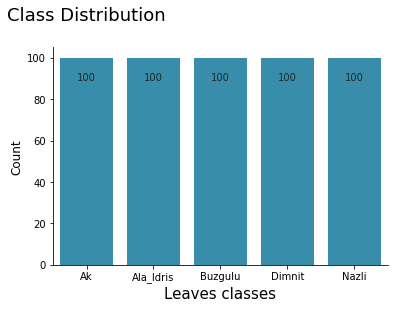

In [ ]:
plot = sns.countplot(x = df['classes'], color = '#2596be')
sns.set(rc={'figure.figsize':(15,13)})
sns.despine()
plot.set_title('Class Distribution\n', x = 0.1, y=1, fontsize = 18);
plot.set_ylabel("Count", x = 0.02, fontsize = 12)
plot.set_xlabel("Leaves classes", fontsize = 15)

for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, -20), textcoords = 'offset points', size = 10)

# **splitting the test and train data**
random_state is seed for random split between test and train data.
we set a number so that every time we run our code the train and test data remain the same.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# **Data Augmentation**

In [ ]:
def Augmentation(X_train , X_val , X_test):
  datagen = ImageDataGenerator(
      rotation_range=90,
      zoom_range=0.10,
      brightness_range=[0.5,1.5],
      channel_shift_range=0.7,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.15,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest',
      preprocessing_function=preprocess_input
  ) 
  train_generator = datagen.flow_from_dataframe(
          X_train,  # This is the source directory for training images
          x_col='path',
          y_col='classes',
          target_size=(200, 200),  # All images will be resized to 200*200
          batch_size=16,
          class_mode="categorical",
          shuffle=True,
  )


  val_generator = datagen.flow_from_dataframe(
          X_val,  # This is the source directory for training images
          x_col='path',
          y_col='classes',
          target_size=(200, 200),  # All images will be resized to 150x150
          batch_size=16,
          class_mode="categorical",
          shuffle=True,
  )

  test_generator = datagen.flow_from_dataframe(
          X_test,  # This is the source directory for training images
          x_col='path',
          y_col='classes',
          target_size=(200, 200),  # All images will be resized to 150x150
          batch_size=16,
          class_mode="categorical",
          shuffle=False,
  )
  return train_generator , val_generator , test_generator



# **Model VGG**

In [ ]:
def model_VGG19():
  vgg19 = VGG19(include_top = False, input_shape = (200,200,3), weights = 'imagenet')

  # training of all the convolution is set to false
  for layer in vgg19.layers:
      layer.trainable = False

  x = GlobalAveragePooling2D()(vgg19.output)
  predictions = Dense(5, activation='softmax')(x)

  model_vgg = Model(inputs = vgg19.input, outputs = predictions)

  return model_vgg

# **compile VGG**

In [ ]:
train_generator , val_generator , test_generator = Augmentation(X_train , X_val , X_test)
model_vgg = model_VGG19()

model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history_vgg = model_vgg.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        verbose=2)
accuracy = model_vgg.evaluate(test_generator)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/30
20/20 - 24s - loss: 2.1936 - accuracy: 0.2313 - val_loss: 1.8359 - val_accuracy: 0.2250 - 24s/epoch - 1s/step
Epoch 2/30
20/20 - 9s - loss: 1.8822 - accuracy: 0.2500 - val_loss: 1.7389 - val_accuracy: 0.2875 - 9s/epoch - 451ms/step
Epoch 3/30
20/20 - 9s - loss: 1.5816 - accuracy: 0.3219 - val_loss: 1.4605 - val_accuracy: 0.3625 - 9s/epoch - 434ms/step
Epoch 4/30
20/20 - 9s - loss: 1.4006 - accuracy: 0.3938 - val_loss: 1.3316 - val_accuracy: 0.4625 - 9s/epoch - 427ms/step
Epoch 5/30
20/20 - 9s - loss: 1.3764 - accuracy: 0.4469 - val_loss: 1.3519 - val_accuracy: 0.4375 - 9s/epoch - 460ms/step
Epoch 6/30
20/20 - 9s - loss: 1.2458 - accuracy: 0.4938 - val_loss: 1.1930 - val_accuracy: 0.4875 - 9s/epoch - 433ms/step
Epoch 7/30
20/20 - 9s - l

# **Model EfficientNetB3**

In [ ]:
def EfficientNetB3():
  base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(200,200,3), pooling='max') 
  # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
  base_model.trainable=True
  x=base_model.output
  x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                  bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x=Dropout(rate=.4, seed=123)(x)       
  output=Dense(5, activation='softmax')(x)
  model_netB3=Model(inputs=base_model.input, outputs=output)
  return model_netB3

# **Compile EffiecentNetB3**

In [ ]:
train_generator , val_generator , test_generator = Augmentation(X_train , X_val , X_test)
model_netB3 = EfficientNetB3()

lr=.001 # start with this learning rate
model_netB3.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

history = model_netB3.fit(
      train_generator,
      validation_data=val_generator,
      epochs=30,
      verbose=2)
accuracy = model_netB3.evaluate(test_generator)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/30
20/20 - 103s - loss: 9.5538 - accuracy: 0.4250 - val_loss: 14.9413 - val_accuracy: 0.2125 - 103s/epoch - 5s/step
Epoch 2/30
20/20 - 11s - loss: 8.7866 - accuracy: 0.5875 - val_loss: 14.2767 - val_accuracy: 0.2125 - 11s/epoch - 562ms/step
Epoch 3/30
20/20 - 10s - loss: 8.5055 - accuracy: 0.5813 - val_loss: 10.4984 - val_accuracy: 0.3750 - 10s/epoch - 525ms/step
Epoch 4/30
20/20 - 11s - loss: 7.8530 - accuracy: 0.7219 - val_loss: 9.1538 - val_accuracy: 0.5875 - 11s/epoch - 549ms/step
Epoch 5/30
20/20 - 10s - loss: 7.5701 - accuracy: 0.7531 - val_loss: 8.4076 - val_accuracy: 0.5875 - 10s/epoch - 509ms/step
Epoch 6/30
20/20 - 12s - loss: 7.3290 - accuracy: 0.7594 - val_loss: 7.6972 - val_accuracy: 0.6875 - 12s/epoch - 590ms/step
Epoch 7/30

# **Confusion matrix**

Accuracy score: 0.98
              precision    recall  f1-score   support

          Ak       0.93      1.00      0.97        28
   Ala_Idris       1.00      0.93      0.96        14
     Buzgulu       1.00      1.00      1.00        10
      Dimnit       1.00      0.96      0.98        24
       Nazli       1.00      1.00      1.00        24

    accuracy                           0.98       100
   macro avg       0.99      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



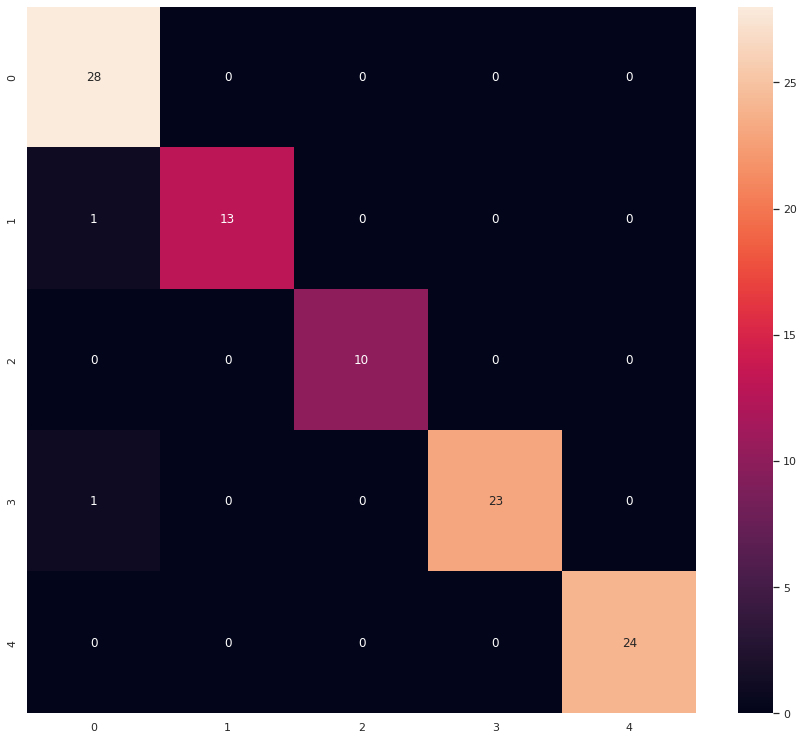

In [ ]:

def report_results(model, y_true, y_predict):
    y_predicted = np.argmax(y_predict, axis=1)
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    y_predicted = np.array([labels[k] for k in y_predicted])
    print(f"Accuracy score: {accuracy_score(y_true, y_predicted)}")
    print(classification_report(y_true, y_predicted))
    mat = confusion_matrix(y_true, y_predicted)
    sns.heatmap(mat, annot=True)

y_predict = model_netB3.predict(test_generator)
y_true=y_test["classes"]
report_results(model_netB3,y_true,y_predict)

# **10 fold cross validation**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)

for i in range(10):
  X_valid, X_train, y_valid, y_train = (X_train.iloc[i*40:i*40+40],pd.concat([X_train.iloc[0:i*40],X_train.iloc[i*40+40:]]),
                                       y_train.iloc[i*40:i*40+40],pd.concat([y_train.iloc[0:i*40],y_train.iloc[i*40+40:]]))
  
  train_generator , val_generator , test_generator = Augmentation(X_train , X_val , X_test)
  model_netB3 = EfficientNetB3()

  lr=.001 # start with this learning rate
  model_netB3.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

  history = model_netB3.fit(
      train_generator,
      validation_data=val_generator,
      epochs=30,
      verbose=2)
  accuracy = model_netB3.evaluate(test_generator)
  print("test accuracy is: ",accuracy[1])
  
  X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)
    
  

Found 360 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
23/23 - 26s - loss: 9.6408 - accuracy: 0.3278 - val_loss: 12.0280 - val_accuracy: 0.3875 - 26s/epoch - 1s/step
Epoch 2/30
23/23 - 10s - loss: 8.9858 - accuracy: 0.5056 - val_loss: 11.1737 - val_accuracy: 0.5000 - 10s/epoch - 428ms/step
Epoch 3/30
23/23 - 10s - loss: 8.4141 - accuracy: 0.6111 - val_loss: 10.6089 - val_accuracy: 0.4375 - 10s/epoch - 425ms/step
Epoch 4/30
23/23 - 10s - loss: 8.0161 - accuracy: 0.6389 - val_loss: 10.3878 - val_accuracy: 0.4000 - 10s/epoch - 425ms/step
Epoch 5/30
23/23 - 10s - loss: 7.7694 - accuracy: 0.6722 - val_loss: 8.6475 - val_accuracy: 0.5500 - 10s/epoch - 420ms/step
Epoch 6/30
23/23 - 10s - loss: 7.3041 - accuracy: 0.7083 - val_loss: 7.9194 - val_accuracy: 0.6125 - 10s/epoch - 422ms/step
Epoch 7/30
23/23 - 11s - loss: 7.0633 - accuracy: 0.7472 - val_loss: 6.8491 

|  Fold Number | test accuracy |
| --- | ---
| 1 | 95
| 2 | 95
| 3 | 93
| 4 | 90
| 5 | 97
| 6 | 92
| 7 | 94
| 8 | 92 
| 9 | 95 
| 10 | 94 

# **10 random seeds**

In [ ]:
for i in range(10):
  seed=rnd.randint(0,10000)   # each seed makes our train and validation and test sets different so we get an average these 10 states.
  X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=seed)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  train_generator , val_generator , test_generator = Augmentation(X_train , X_val , X_test)
  model_netB3 = EfficientNetB3()

  lr=.001 # start with this learning rate
  model_netB3.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

  history = model_netB3.fit(
      train_generator,
      validation_data=val_generator,
      epochs=30,
      verbose=2)
  accuracy = model_netB3.evaluate(test_generator)
  print("test accuracy is: ",accuracy[1])

|  seed Number | test accuracy |
| --- | ---
| 1 | 93
| 2 | 91
| 3 | 96
| 4 | 95
| 5 | 94
| 6 | 91
| 7 | 92
| 8 | 90 
| 9 | 95 
| 10 | 92 

average accuracy is 92.9%